In [135]:
import pandas as pd
import numpy as np
from pathlib import Path
from pandas import read_table
from pylab import rcParams
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
from matplotlib.pyplot import figure
import warnings
import datetime
from scipy.stats import chi2_contingency
from pqdm.processes import pqdm
warnings.filterwarnings('ignore')

In [2]:
class Notebook(object):
    def __init__(self, name):
        self.name = name
        self.notes = []
        self.params = {}
        print(f'Notebook {name} created.')
    
    def log(self, note, category='misc'):
        self.notes.append((category, note))
        
    def retrieve(self, category=None):
        df = pd.DataFrame(self.notes, columns = ['category', 'note'])
        if category:
            return df[df.category==category]
        else:
            return df
        
    def log_param(self, name, param):
        self.params[name] = param
    
    def __len__(self):
        return len(self.notes)

In [3]:
notebook = Notebook('PerturbNet-HNSC')

Notebook PerturbNet-HNSC created.


## Goal: Learn a three-layer network from Z (traits), Y (gene expressions), and X (SNP data).

Z: array of shape (n, r)
            
    The data matrix with n samples and r traits. ==>> traits
        
Y: array of shape (n_o, q)
    
    The data matrix with n_o samples and q genes. ==>> expression

X: array of shape (n, p) 
    ==>> mutations 

_________

all_thresholded.by_genes.txt

**A gene-level table of discrete amplification and deletion indicators for all samples.** 

- A table value of 0 means no amplification or deletion above the threshold. 
- Amplifications are positive numbers: 1 means amplification above the amplification threshold; 2 means amplifications larger to the arm level amplifications observed for the sample. 
- Deletions are represented by negative table values: -1 represents deletion beyond the threshold; -2 means deletions greater than the minimum arm-level deletion observed for the sample. 

Results maybe filtered by cohort, gene or barcode, but at least one gene or barcode must be supplied.

In [4]:
special_genes = """
RELA
PBX1
SPI1
HIVEP1
MXI1
TBX19
DNMT1
SMARCC1
ZNF410
HMBOX1
TFEB
HINFP
NFYA
BPTF
CREB1
AR
STAT6
TERT
""".split()

In [5]:
# Gene Expression Differences Associated with Human Papillomavirus Status in Head and Neck Squamous Cell Carcinoma
# https://clincancerres.aacrjournals.org/content/12/3/701
data_tables = pd.read_html('https://clincancerres.aacrjournals.org/content/12/3/701.figures-only')
known_genes = data_tables[2]['HUGO ID'].dropna().values.reshape(-1, )

_____________

In [6]:
root_dir = Path('/ihome/hosmanbeyoglu/kor11/tools/PerturbNet/TCGA')
cancer = 'HNSC'
notebook.log_param('cancer', cancer)

In [7]:
# clinical = pd.read_csv(root_dir / cancer / 'Clinical' / f'{cancer}.clin.merged.txt', delimiter='\t').T
mutations = pd.read_csv(root_dir / cancer / 'data_mutations.txt', delimiter='\t')
clinical2 = pd.read_csv(root_dir / cancer / 'hnsc_tcga_pan_can_atlas_2018_clinical_data.tsv', delimiter='\t')

In [8]:
# clinical.columns = clinical.iloc[0]
# clinical = clinical[1:]

In [9]:
trait_selection = {
        'patient.bcr_patient_barcode': 'Patient ID',            
#         'patient.gender': 'sex',
#         'patient.age_at_initial_pathologic_diagnosis': 'age',
        'patient.tobacco_smoking_history': 'smoking',
#         'patient.presence_of_pathological_nodal_extracapsular_spread': 'pnes',
#         'patient.stage_event.pathologic_stage': 'stage', 
        # 'patient.number_of_lymphnodes_positive_by_he': 'lymph', 
#         'patient.person_neoplasm_cancer_status': 'neo',
        # 'patient.hpv_test_results.hpv_test_result.hpv_status': 'hpv',
        'Subtype': 'hpv',
        'Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code': 'lymph',
        # 'Person Neoplasm Cancer Status': 'neo',
        'Overall Survival Status': 'survival',
#         'patient.amount_of_alcohol_consumption_per_day': 'alcohol',
#         'patient.follow_ups.follow_up.primary_therapy_outcome_success': 'outcome'

}
notebook.log_param('traits', trait_selection)

In [10]:
# cbioportal = clinical2[['Patient ID', 'Subtype']]
# fire = clinical[['patient.bcr_patient_barcode', 'patient.hpv_test_results.hpv_test_result.hpv_status']]
# fire.columns.name = None
# fire = fire.reset_index().drop('index', axis=1)
# fire['patient.bcr_patient_barcode'] = fire['patient.bcr_patient_barcode'].str.upper()
# cbioportal.Subtype = cbioportal.Subtype.replace({'HNSC_HPV-': 'negative', 'HNSC_HPV+': 'positive'})

# fire = fire.dropna()
# cbioportal = cbioportal.dropna()

# inconsistent = []
# for i in cbioportal['Patient ID']:
#     res1 = cbioportal[cbioportal['Patient ID'] == i]['Subtype'].values[0]
#     res2 = fire[fire['patient.bcr_patient_barcode'] == i]['patient.hpv_test_results.hpv_test_result.hpv_status'].values[0]
#     if res1 != res2:
#         inconsistent.append(i)
# print(len(inconsistent))


In [11]:
# clinical['patient.bcr_patient_barcode'] = clinical['patient.bcr_patient_barcode'].str.upper()
# clinical.index = clinical['patient.bcr_patient_barcode']
# clinical.index.name = None

# clinical = clinical2[['Overall Survival Status', 
#     # 'Person Neoplasm Cancer Status', 
#     'Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code', 
#     'Patient ID']].join(clinical[[k for k, v in trait_selection.items() if k in clinical.columns]], on='Patient ID')

In [12]:
# traits = clinical[[k for k, v in trait_selection.items() if k in clinical.columns]]
# traits.columns = [v for k, v in trait_selection.items() if k in clinical.columns]
# traits.index = traits['Patient ID'].str.upper()
# traits = traits.drop('Patient ID', axis=1)
# traits.index.name = None
# # traits.survival = traits.survival.apply(lambda x: x.split(':')[0]).astype(int)
# traits = traits[traits.hpv != 'indeterminate']
# traits

In [13]:
# pd.DataFrame(((traits.isna().sum() / len(traits)) * 100), columns = ['Missing (%)']).T

In [14]:
# smoking_code = {
#     1 : 'Lifelong Non-Smoker',
#     2 : 'Current Smoker',
#     3 : 'Current Reformed Smoker > 15 years',
#     4 : 'Current Reformed Smoker <= 15 years',
#     5 : 'Current Reformed Smoker Unspecified years',
#     6 : 'Smoker at Diagnosis',
#     7 : 'Not Documented'
# }

In [15]:
traits = clinical2[['Patient ID', 'Subtype']].set_index('Patient ID')
traits = traits.dropna()
traits.index.name = None
traits.columns = ['hpv']
traits.hpv = traits.hpv.replace({'HNSC_HPV-': 0, 'HNSC_HPV+': 1})
traits = traits.astype(int)
traits

,hpv
TCGA-4P-AA8J,0
TCGA-BA-4074,0
TCGA-BA-4076,0
TCGA-BA-4078,0
TCGA-BA-5149,0
...,...
TCGA-UF-A7JT,0
TCGA-UF-A7JV,0
TCGA-UP-A6WW,1
TCGA-WA-A7GZ,0


In [16]:
traits = traits.dropna()
traits.hpv.value_counts()

0    415
1     72
Name: hpv, dtype: int64

In [17]:
# traits.smoking.astype(int).replace(smoking_code).value_counts()

In [18]:
# traits.survival = traits.survival.replace({'1:DECEASED': 1, '0:LIVING': 0})
# traits.hpv = traits.hpv.replace({'negative': 0, 'positive': 1})
# traits.lymph = [int(i not in ['N0', 'NX']) for i in traits.lymph]
# traits.smoking = traits.smoking.astype(int).replace({1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: np.nan})
# traits = traits.dropna()

__________

In [19]:
mutations = pd.read_csv(root_dir / cancer / 'data_mutations.txt', delimiter='\t')

m0 = len(mutations)
mutations = mutations[(mutations['Variant_Classification'] != 'Silent')]
m1 = len(mutations)
mutations = mutations[(mutations['IMPACT'] != 'LOW')]
m2 = len(mutations)

print(f'Filtered out {m0-m2} samples')
notebook.log(f'Filtered out {m0-m2} samples', 'filtering')

Filtered out 29288 samples


In [20]:
mutated_genes = pd.read_csv(root_dir / cancer / 'Mutated_Genes.txt', delimiter='\t')
mutated_genes['Freq'] = mutated_genes['Freq'].str[:-1].astype(float)

In [21]:
# cnv = clinical2[clinical2.columns[52:-10]].replace({'Not Called': 0, 'Lost': 1, 'Gained': 2}).fillna(0).astype(int)
# cnv.index = clinical2['Patient ID']
# cnv.index.name = None

# cnvs = []
# for i in cnv.columns:
#     cnvs.append(i.split()[0] + '_del')
#     cnvs.append(i.split()[0] + '_amp')    
    
# cnv2 = pd.DataFrame(columns = cnvs, index = cnv.index)

# for i in cnv.T.iteritems():
#     p = i[0]
#     for locus, value in i[1].iteritems():
#         if value == 1:
#             cnv2.loc[p, locus.split()[0] + '_del'] = 1
#         if value == 2:
#             cnv2.loc[p, locus.split()[0] + '_amp'] = 1    
            
# cnv2 = cnv2.fillna(0)

In [22]:
# cutoff = 0.05
# selected_genes = mutations['Hugo_Symbol'].value_counts() /  len(set(mutations['Tumor_Sample_Barcode'])) > cutoff
# notebook.log_param('mutation_cutoff', cutoff)

In [23]:
# mutations = mutations[mutations['Hugo_Symbol'].apply(lambda x: selected_genes[x])]
mutations['Barcode'] = mutations['Tumor_Sample_Barcode'].str[:-3]

In [24]:
mutation_matrix = pd.DataFrame(columns=set(mutations['Hugo_Symbol']), index = traits.index).fillna(0)

In [25]:
for patient_id in traits.index:
    for m in set(mutations[mutations.Barcode == patient_id]['Hugo_Symbol']):
        mutation_matrix.loc[patient_id, m] = 1

In [40]:
rnaseq = pd.read_csv(root_dir / cancer / 'data_mrna_seq_v2_rsem.txt' , delimiter='\t')
rnaseq.index = rnaseq['Hugo_Symbol']
rnaseq.index.name = None
rnaseq = rnaseq.drop(['Hugo_Symbol', 'Entrez_Gene_Id'], axis=1)
rnaseq.columns = rnaseq.columns.str[:-3]
rnaseq = rnaseq[rnaseq.index.notnull()].dropna().drop_duplicates()
rnaseq = rnaseq[~rnaseq.index.duplicated(keep='first')]
rnaseq = rnaseq.loc[:,~rnaseq.columns.duplicated()]

In [41]:
expression_cutoff = 200
rnaseq = rnaseq[rnaseq.mean(1) > expression_cutoff]
notebook.log_param('expression_cutoff', expression_cutoff)

In [42]:
mutation_matrix = mutation_matrix[set(mutated_genes.query('Freq > 5').sort_values(by='Freq', ascending=False).Gene) & set(mutations['Hugo_Symbol'])]

In [43]:
# rnaseq = np.log10(rnaseq + 1)

In [44]:
rnaseq = rnaseq[~(rnaseq.var(1) < 0.1)]

In [46]:
import seaborn as sns

In [56]:
rnaseq = rnaseq[traits.hpv.sort_values().index]

,TCGA-CV-7236,TCGA-CN-6012,TCGA-CV-7235,TCGA-CV-A45O,TCGA-CV-A6K2,TCGA-DQ-5624,TCGA-CV-7099,TCGA-HD-8224,TCGA-CN-4738,TCGA-CV-6959,...,TCGA-IQ-A61I,TCGA-CR-7368,TCGA-DQ-7591,TCGA-MZ-A6I9,TCGA-CN-A6V1,TCGA-BA-A4IF,TCGA-BA-A4IG,TCGA-P3-A5QE,TCGA-BB-4228,TCGA-HD-7754
MXI1,-0.405906,0.163468,0.611695,0.662693,-0.007449,0.079336,-0.215208,0.060886,-0.129003,0.050361,...,-0.538306,-0.183439,0.240398,0.229392,-0.302923,0.527054,0.621628,0.292436,0.619833,0.458070
DNMT1,0.908352,1.019631,0.971439,0.301607,0.612082,0.317013,0.911566,0.923681,0.680971,1.025538,...,1.017480,1.488955,1.135610,1.049488,0.972924,1.377505,1.308890,1.448659,1.313825,1.371790
BPTF,0.882456,0.636644,0.103741,0.402954,0.218302,0.078197,0.460701,0.719069,0.724183,0.573934,...,-0.116708,0.868902,0.652322,0.287717,0.067687,0.719215,0.459100,0.825430,0.360735,0.875154
PBX1,-0.136882,0.141892,-0.154503,-1.325170,0.017038,-0.511964,-0.425664,1.047329,-0.187342,-1.144234,...,0.764788,0.711010,1.067632,-0.198875,-0.037637,-1.118917,0.346558,0.813009,0.932971,1.471463
SMARCC1,0.728509,1.087305,0.992436,0.628012,0.931235,0.928100,0.787905,0.805714,1.164708,0.976065,...,0.241868,0.869000,0.876746,1.092493,0.697965,1.004995,1.422807,1.188899,1.226383,1.724423
STAT6,1.518946,1.564517,1.200018,1.411946,1.426972,1.920688,1.516277,1.203031,1.693280,1.678628,...,1.355781,1.661374,1.330852,0.933069,1.391720,1.226516,1.067075,1.377416,1.201480,1.315104
CREB1,0.238161,-0.063144,0.064131,0.260532,0.324709,0.472829,0.136394,0.610658,0.323962,0.402189,...,-0.080963,0.348343,0.433154,-0.012378,0.050008,0.344282,0.143371,0.487140,0.390337,0.466233
HIVEP1,0.275149,0.117673,0.267944,-0.088835,-0.142722,0.363308,0.347542,-0.339225,0.309935,0.608082,...,-0.303174,0.703495,1.145724,-0.257767,-0.797825,-0.056930,0.267717,1.091319,0.789969,0.351005
HINFP,-0.618340,-1.111284,-0.624401,-0.305531,-0.823574,-0.978289,-0.829618,-0.542248,-0.927765,-0.962511,...,-0.415200,-0.695380,-0.631298,-0.536427,-0.300248,-1.066350,-0.991875,-0.359564,-0.742868,-0.656785
TFEB,-0.147083,-0.617527,0.090164,-0.560068,-0.119685,-0.894704,-0.654908,0.363324,-0.372206,-0.198897,...,-0.442073,-0.112504,-0.729147,-0.126420,0.731485,-0.387253,-0.427477,-0.036017,-0.640712,-0.816789


In [95]:
log2rnaseq = np.log2(rnaseq + 1)

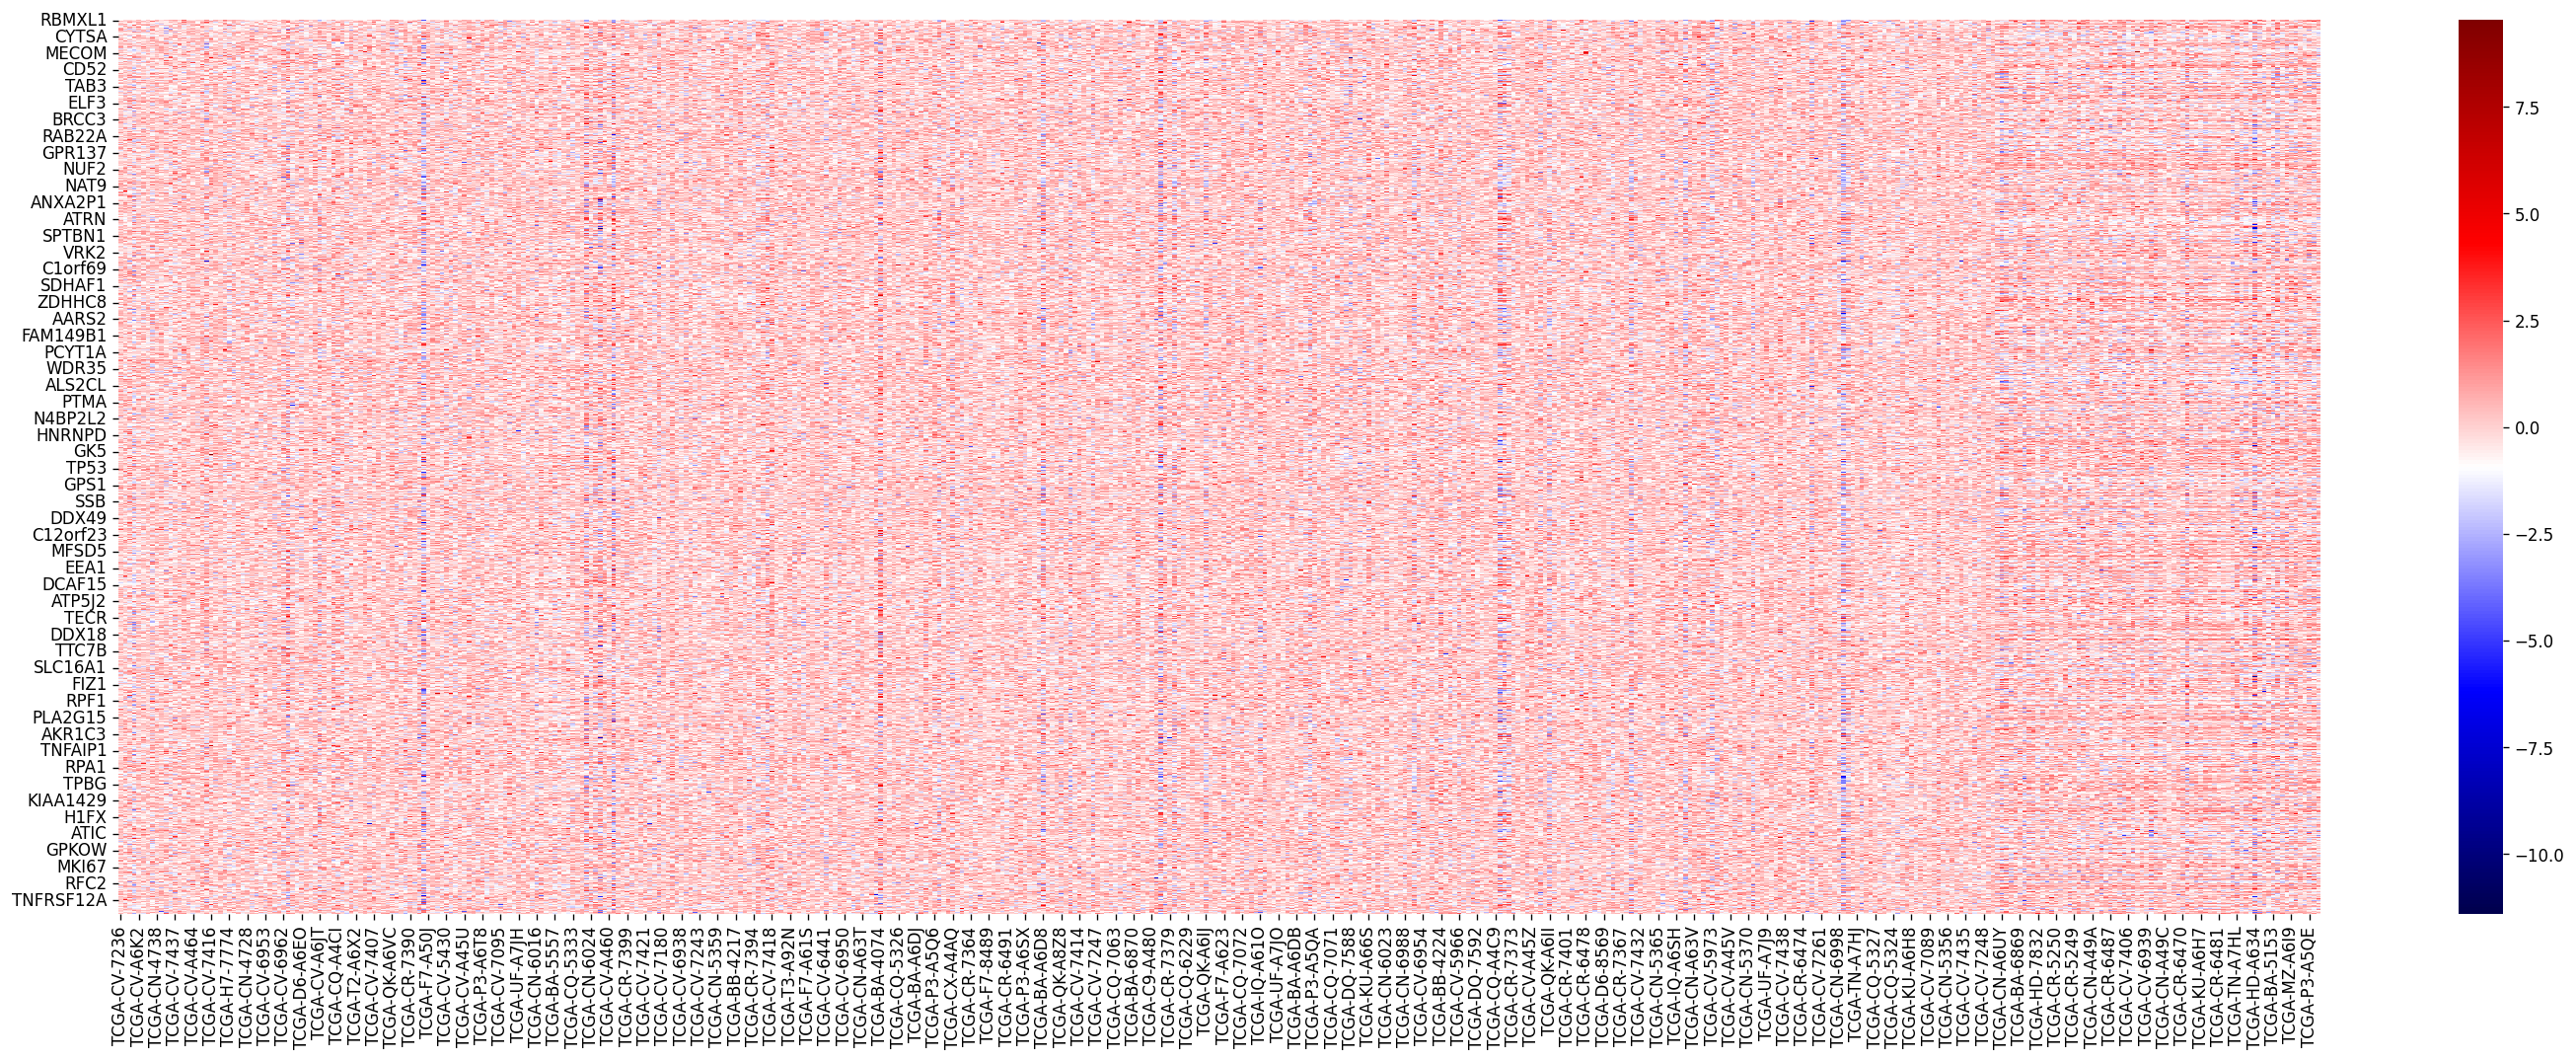

In [192]:
figure(figsize=(30, 10), dpi=120)
raw_ = np.log2(rnaseq + 1)
raw_ = raw_.loc[pd.DataFrame(r, index=rnaseq.index).sort_values(by=0)[:7000].index]
raw_ = raw_.sample(len(raw_))
raw_ = raw_.subtract(raw_.mean(1), 0).div(raw_.std(1), 0)
# raw_ = raw_.subtract(raw_.mean(1), 0)
# raw_ = raw_.subtract(raw_.mean(0), 1).div(raw_.std(0), 1)
sns.heatmap(raw_, cmap="seismic")
plt.show()

In [180]:
len(raw_)

8000

In [139]:
from collections import namedtuple
from scipy.stats import ttest_ind as ttest

Result = namedtuple('Result', ['hpv_positive', 'hpv_negative', 'pvalue'])

def compare(gene, df=log2rnaseq):

    hpv_p = df.loc[gene][traits[traits.hpv == 1].index]
    hpv_n = df.loc[gene][traits[traits.hpv == 0].index]

    hpv_p_mean = hpv_p.mean()
    hpv_p_std = hpv_p.std()

    hpv_n_mean = hpv_n.mean()
    hpv_n_std = hpv_n.std()

    pvalue = ttest(hpv_p, hpv_n).pvalue

    # return Result([hpv_p_mean, hpv_p_std], [hpv_n_mean, hpv_n_std], pvalue)
    return pvalue


In [162]:
r = pqdm(rnaseq.index, compare, 20)

SUBMITTING | :   0%|          | 0/10738 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/10738 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/10738 [00:00<?, ?it/s]

In [194]:
rnaseq = log2rnaseq.loc[pd.DataFrame(r, index=rnaseq.index).sort_values(by=0)[:7000].index]

In [195]:
# merged = mutation_matrix.join(cnv2)
merged = mutation_matrix
# merged = cnv2

common_samples = set(rnaseq.columns) & set(merged.index)
rnaseq = rnaseq[common_samples]
merged = merged.loc[common_samples]

traits = traits.loc[set(merged.index) & set(traits.index)].astype(int)
merged = merged.loc[set(merged.index) & set(traits.index)].astype(int)
rnaseq = rnaseq[set(merged.index) & set(traits.index)]

In [196]:
# import scipy.stats as stats
# import pylab
# stats.probplot(rnaseq.mean(1).values, dist="norm", plot=pylab)
# plt.show()

In [197]:
rnaseq = rnaseq.subtract(rnaseq.mean(1), 0).div(rnaseq.std(1), 0)

In [198]:
# cna = pd.read_csv(root_dir / 'HNSC' / 'data_CNA.txt', delimiter='\t')
# cna = cna[~cna['Entrez_Gene_Id'].isnull()].set_index('Hugo_Symbol').drop('Entrez_Gene_Id', axis=1)
# cna.index.name = None
# cna.columns = cna.columns.str[:-3]
# cna = cna[~cna.index.duplicated(keep='first')]

In [199]:
# traits = (traits - traits.mean()) / traits.std()

In [200]:
rnaseq.shape, traits.shape, merged.shape

((7000, 487), (487, 1), (487, 116))

In [201]:
Z = traits.to_numpy()
Y = rnaseq.T.to_numpy()
X = merged.to_numpy()

Z.shape, Y.shape, X.shape

((487, 1), (487, 7000), (487, 116))

In [202]:
r = Z.shape[1]
n = X.shape[0]
q = Y.shape[1]
p = X.shape[1]
assert X.shape[0]==Z.shape[0]
assert Y.shape[0]<=n

print(f'{r} traits\n{n} samples,\n{q} genes\n{p} mutations')

1 traits
487 samples,
7000 genes
116 mutations


In [203]:
notebook.log_param('matrices', {'traits': r, 'samples': n, 'genes': q, 'mutations': p})

In [204]:
root_dir / cancer

PosixPath('/ihome/hosmanbeyoglu/kor11/tools/PerturbNet/TCGA/HNSC')

In [205]:
np.savetxt(root_dir / cancer / 'traits.txt', Z, delimiter='\t', fmt='%s')
np.savetxt(root_dir / cancer / 'expression.txt', Y, delimiter='\t', fmt='%s')
np.savetxt(root_dir / cancer / 'genotype.txt', X, delimiter='\t', fmt='%s')
traits.to_csv(root_dir / cancer / 'traits_data.csv')
merged.to_csv(root_dir / cancer / 'mutations_data.csv')
rnaseq.to_csv(root_dir / cancer / 'rnaseq_data.csv')
notebook.log_param('timestamp', datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S"))

In [206]:
import json

with open(root_dir / cancer / 'nb_params.json', 'w') as f:
    f.write(json.dumps(notebook.params))
    
print(f'Saved params to {root_dir / cancer / "nb_params.json"}')

Saved params to /ihome/hosmanbeyoglu/kor11/tools/PerturbNet/TCGA/HNSC/nb_params.json
